In [2]:
import pickle
import matplotlib.pyplot as plt

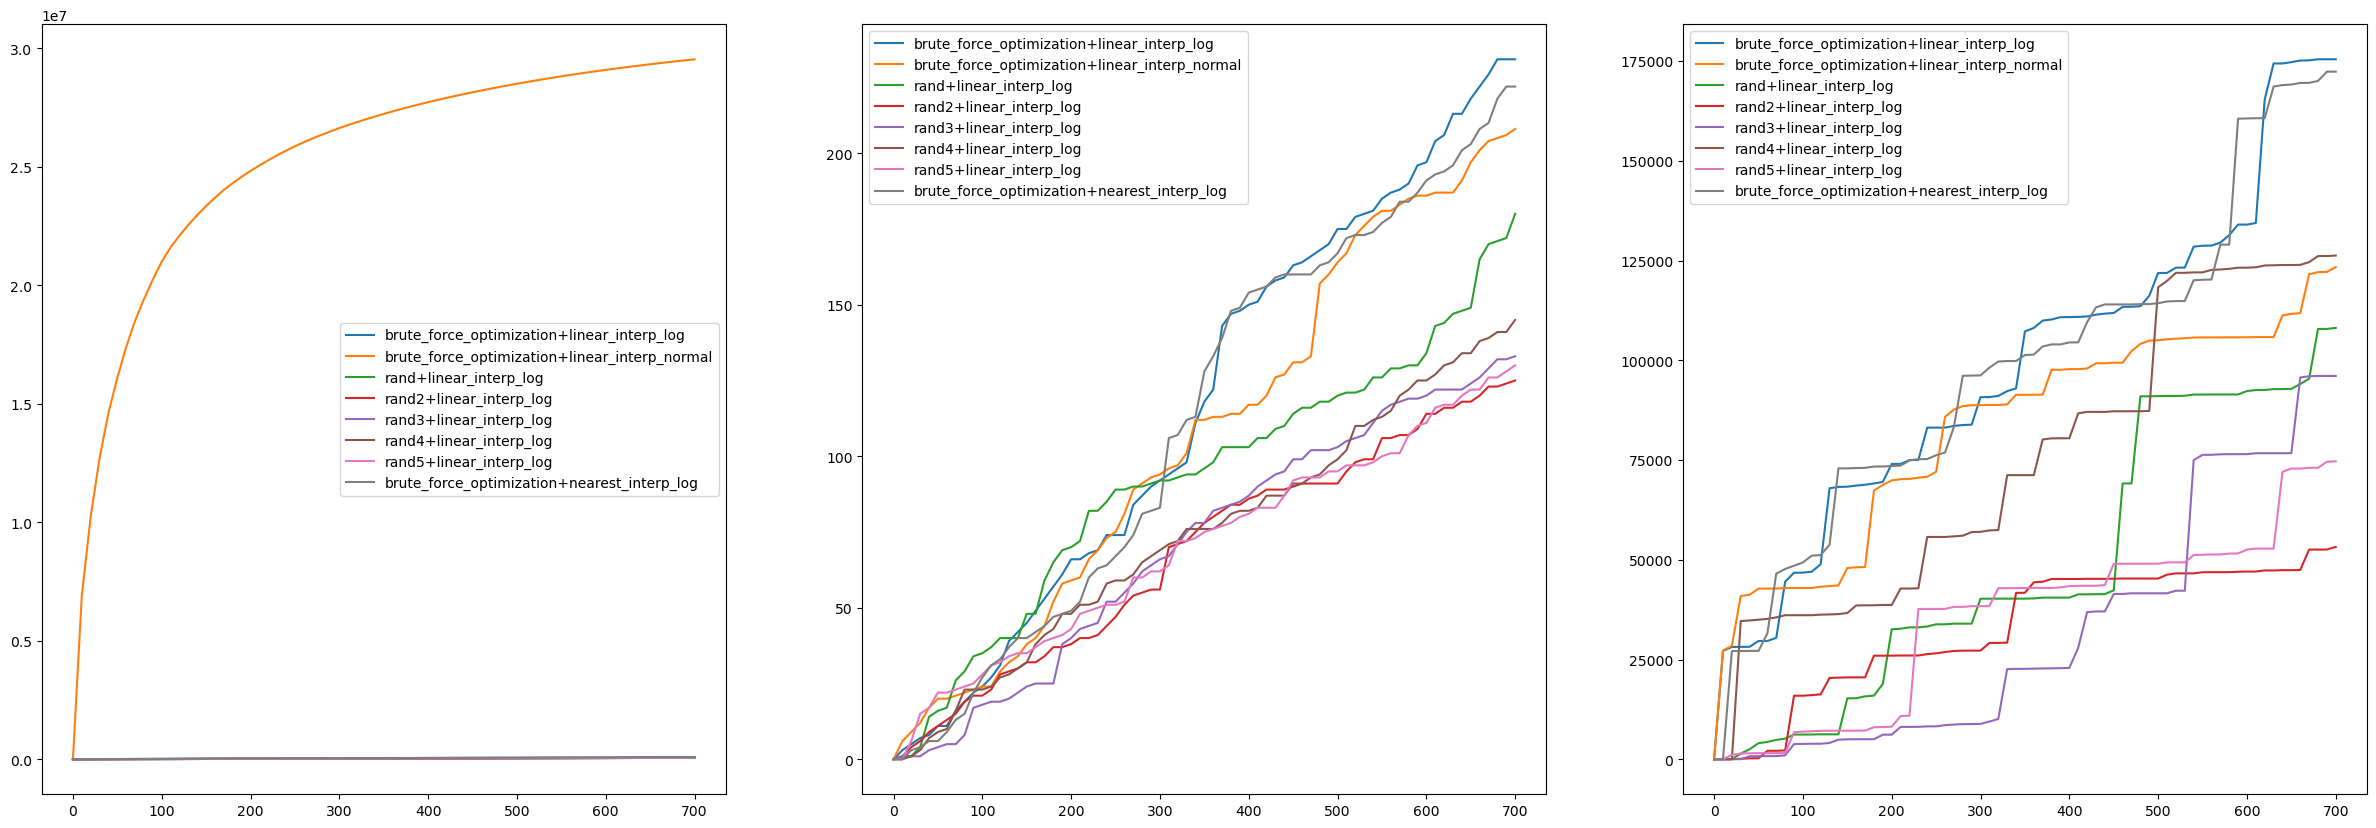

In [26]:
files = ['./tradeoff_results/brute_force_optimization+linear_interp_log', './tradeoff_results/brute_force_optimization+linear_interp_normal', 
         './tradeoff_results/rand+linear_interp_log', './tradeoff_results/rand2+linear_interp_log', './tradeoff_results/rand3+linear_interp_log',
        './tradeoff_results/rand4+linear_interp_log', './tradeoff_results/rand5+linear_interp_log', './tradeoff_results/brute_force_optimization+nearest_interp_log']
xs, y1s, y2s, y3s = [], [], [], []
for file in files:
    with open(file, 'rb') as fp:
        x, y1, y2, y3 = pickle.load(fp)
        xs.append(x)
        y1s.append(y1)
        y2s.append(y2)
        y3s.append(y3)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (30,10))

for ind in range(len(xs)):
    ax[0].plot(xs[ind], y1s[ind], label = files[ind].split("/")[-1])
    ax[1].plot(xs[ind], y2s[ind], label = files[ind].split("/")[-1])
    ax[2].plot(xs[ind], y3s[ind], label = files[ind].split("/")[-1])
    
ax[0].legend()
ax[1].legend()
ax[2].legend()

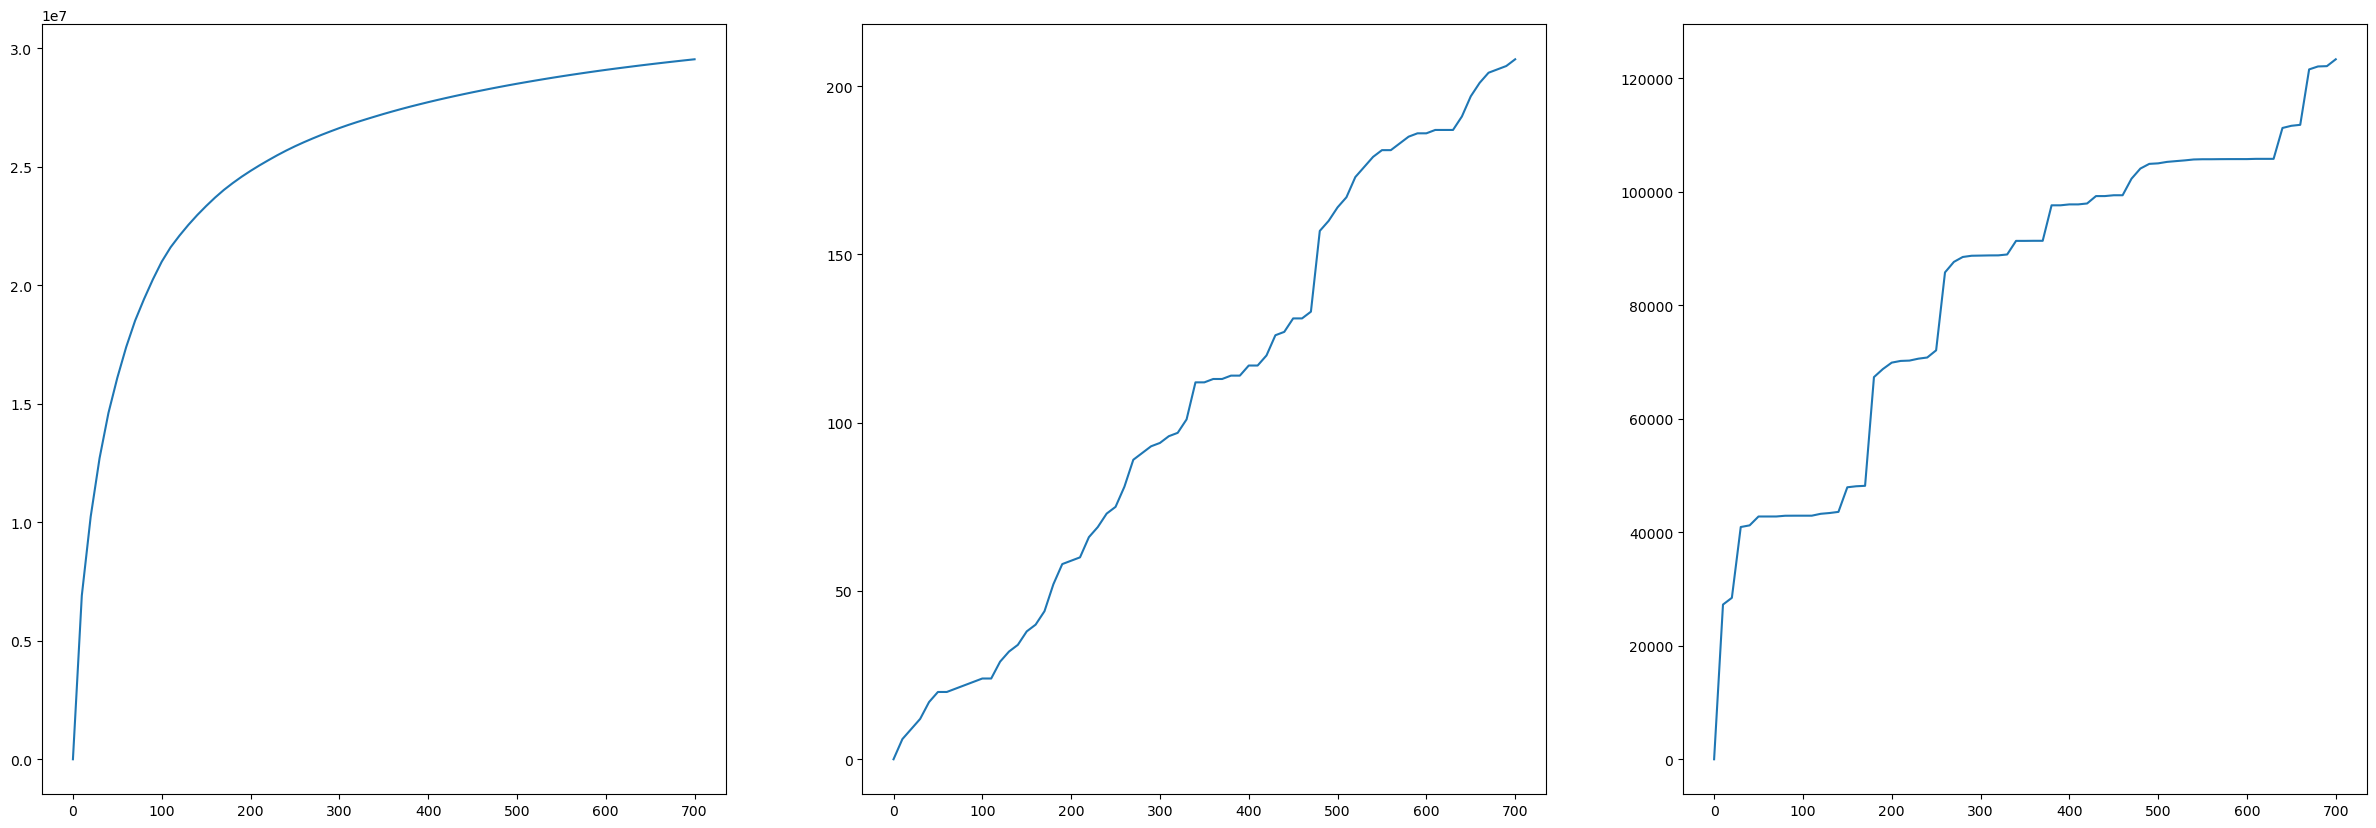

In [18]:
with open('./tradeoff_results/brute_force_optimization+linear_interp_normal', 'rb') as fp:
    x, y1, y2, y3 = pickle.load(fp)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (30,10))
ax[0].plot(x, y1)
ax[1].plot(x, y2)
ax[2].plot(x, y3)